# CASE 2

#### Table of Content
- Evolution of Monthly and Annual Export of Soy Products from Brazilian States
- Annual Export of Soy Products from Brazilian States - Map
- Corn Export Routes from Brazil in 2010-2019
- Top Corn and Sugar Trade Partners in 2017-2019
- Top Exporter States Per Product
- Forecasts of Brazil's Export of Soybeans, Soybean Meal, and Corn for 2020-2030

#### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
pd.set_option("display.precision", 3)
from IPython.display import display
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
import chart_studio
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import sklearn

mapbox_access_token = 'insert-token'
chart_studio.tools.set_credentials_file(username='insert-username', api_key='insert-key')

#### Load Data

In [2]:
df = pd.read_csv("data_comexstat.csv", encoding='latin-1')
df['date'] = df['date'].astype('datetime64[ns]')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [3]:
df.describe()

tons        usd        year       month
count  1.180e+05  1.180e+05  117965.000  117965.000
mean   1.454e+04  4.813e+06    2010.997       6.799
std    4.978e+04  1.949e+07       6.164       3.305
min    0.000e+00  0.000e+00    1997.000       1.000
25%    1.249e+02  7.155e+04    2007.000       4.000
50%    2.000e+03  7.250e+05    2012.000       7.000
75%    1.353e+04  3.896e+06    2016.000      10.000
max    1.798e+06  9.039e+08    2019.000      12.000

### Evolution of Monthly and  Annual Export of Soy Products from Brazilian States

In [4]:
# Export per state
soy_prods = df[(df["product"].isin(['soybeans', "soybean_meal", "soybean_oil"])) & (df["type"] == 'Export')]
agg_soy_prods = soy_prods.groupby(['product', 'year', 'date', 'state', 'country']).sum()
agg_soy_prods.reset_index(inplace=True)

In [5]:
# Create records that represent cumulative export from the whole country
df_brazil = agg_soy_prods.groupby(['product', 'year', 'date', 'country']).sum()
df_brazil['state'] = 'ALL'
df_brazil.reset_index(inplace=True)

In [6]:
# Join 
agg_soy_prods = pd.concat([agg_soy_prods, df_brazil], axis=0)

In [7]:
agg_soy_prods.head()

product  year       date state      country       tons        usd  \
0  soybean_meal  1997 1997-01-01    GO  Netherlands   5419.070  1.534e+06   
1  soybean_meal  1997 1997-01-01    MS      Germany    140.672  3.838e+04   
2  soybean_meal  1997 1997-01-01    MS      Hungary  15000.000  4.042e+06   
3  soybean_meal  1997 1997-01-01    MS  Netherlands  14000.000  3.850e+06   
4  soybean_meal  1997 1997-01-01    MT      Germany   5000.000  1.397e+06   

   month  
0      2  
1      1  
2      1  
3      1  
4      1

In [8]:
px.line(agg_soy_prods[agg_soy_prods['state'] != 'ALL'], 
        x="date", 
        y="tons", 
        color="state", 
        title="Monthly Export of Soy Products from Brazilian States in 1997-2019")

In [9]:
annual_soy_prods = agg_soy_prods.groupby(['product', 'year', 'state']).sum()
annual_soy_prods.reset_index(inplace=True)

px.line(annual_soy_prods[annual_soy_prods['state'] != 'ALL'], 
        x="year", 
        y="tons", 
        color="state", 
        title="Annual Export of Soy Products from Brazilian States in 1997-2019")

### Annual Export of Soy Products from Brazilian States - Map

In [10]:
def plot_soy_export(year, df=agg_soy_prods, metric='tons', product=['soybeans', 'soybean_meal', 'soybean_oil']):
    
    # Define plot layout
    layout = dict(height = 500,
                  margin = dict(t = 0, b = 0, l = 0, r = 0), # top, bottom, left and right margins
                  font = dict(color = '#000000', size = 11),
                  paper_bgcolor = '#FFFFFF',
                  mapbox = dict(accesstoken = mapbox_access_token,
                                bearing = 0,
                                center = dict(lat = 38, lon = -94), # where we want the map to be centered
                                pitch = 0, # we want the map to be "parallel" to our screen, with no angle
                                zoom = 3, # default level of zoom
                                style = 'light')) # default map style

#     layout['title'] = 'Export of Soy Derivatives'

    # Define plot annotations
    annotations = [dict(text = f'Export of Soy Products by Brazilian States in {year}',
                        font = dict(color = '#000000', size = 14), borderpad = 10,  # font and border characteristics
                        x = 0.05, y = 0.05, xref = 'paper', yref = 'paper', align = 'left',  # positional arguments
                        showarrow = False, bgcolor = 'white')] # don't show arrow and set background color

    layout['annotations'] = annotations

    # Define dynamic variable
    all_states = set(df['state'])
    button_states = []
    for i, state in enumerate(all_states):
        visibility = [False for i in range(len(all_states))]
        visibility[i] = True

        button_states.append(dict(label = str(state),
                                  method = 'update',
                                  args = [{'visible': visibility}]))

    updatemenus=list([dict(buttons = button_states,
                      direction = 'down', # direction where the drop-down expands when opened
                      x = 0.01, xanchor = 'left', y = 0.99, yanchor = 'bottom', # positional arguments     
                      bgcolor = '#FFFFFF', bordercolor = '#000000', font = dict(size=11))]) # fonts and border


    layout['updatemenus'] = updatemenus
    
    # Select data to plot
    select_year = df['year'] == year
    select_product = df['product'].isin(product)
    select_metric = metric
    
    # Prepare data to plot
    data_to_plot = df.loc[(select_year & select_product), [select_metric, 'state', 'country']] \
                     .groupby(['state', 'country']).sum()
    data_to_plot.reset_index(inplace=True)

    data = []
    for state in all_states:
        state_data = dict(locations = data_to_plot.loc[(data_to_plot['state'] == state), 'country'],
                          locationmode = 'country names',
                          name = state,
                          z = data_to_plot.loc[data_to_plot['state'] == state, select_metric],
                          type = 'choropleth')
        data.append(state_data)
    
    # Plot
    figure = dict(data = data, layout = layout)
    return py.iplot(figure, filename = 'export_soy_products')

In [11]:
plot_soy_export(year=2005, product=['soybeans', 'soybean_meal', 'soybean_oil'])

In [12]:
plot_soy_export(year=2019, product=['soybeans', 'soybean_meal', 'soybean_oil'])

### Most Important Products Exported by Brazil in the last 5 years

In [13]:
# Aggregate data by product from the last 5 years
df2 = df.loc[(df['year'] > 2014) & (df['type'] == 'Export'), ['product', 'tons', 'usd']] \
          .groupby('product') \
          .sum() \
          .sort_values('usd', ascending = False) 
        
df2.reset_index(inplace=True)

# We will consider tons in millions and USD in billions
df2['mln tons'] = df2['tons'].div(1e6)
df2['bln usd'] = df2['usd'].div(1e9)

In [14]:
df2[['product', 'mln tons', 'bln usd']]

product  mln tons  bln usd
0      soybeans   326.331  123.326
1         sugar   120.034   40.938
2  soybean_meal    76.647   28.408
3          corn   144.599   24.448
4   soybean_oil     6.711    4.796
5         wheat     3.886    0.727

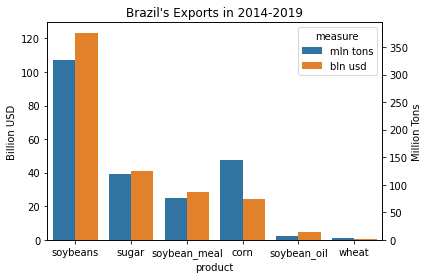

In [15]:
# Unpivot Dataframe for plotting
melted = pd.melt(frame=df2, \
                 id_vars='product',\
                 value_vars=["mln tons", "bln usd"], \
                 var_name="measure", value_name="value")

# Scale tons
mask = melted['measure'] == 'mln tons'
scale = (melted[~mask]['value'].mean() / melted[mask]['value'].mean())
melted.loc[mask, 'value'] = melted.loc[mask, 'value'] * scale

# Plot
fig, ax1 = plt.subplots()
g = sns.barplot(x='product', y="value", hue="measure", data=melted)

# Create a second y-axis with scaled axis
ax1.set_ylabel('Billion USD')
ax2 = ax1.twinx()
ax2.set_ylabel('Million Tons')
ax2.set_ylim(ax1.get_ylim() / scale)
g.set_title('Brazil\'s Exports in 2014-2019');

### Corn Export Routes from Brazil in 2010-2019

In [16]:
df3 = df.loc[(df['year'] > 2010) & (df['product'] == 'corn') & (df['type'] == 'Export'), ['route', 'year', 'tons']] \
          .groupby(['year', 'route']) \
          .sum() \
          .sort_values('year', ascending = False) 
df3['mln tons'] = df3['tons'].div(1e6)

In [17]:
df3.head(10)

tons   mln tons
year route                       
2019 Sea     4.153e+07  4.153e+01
     River   7.865e+04  7.865e-02
     Other   1.985e+05  1.985e-01
     Ground  2.137e+04  2.137e-02
     Air     6.406e+01  6.406e-05
2018 Sea     2.121e+07  2.121e+01
     River   1.461e+06  1.461e+00
     Other   6.055e+04  6.055e-02
     Ground  1.528e+04  1.528e-02
     Air     1.159e+02  1.159e-04

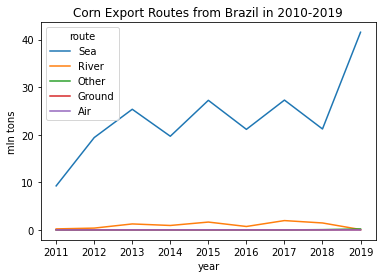

In [18]:
g2 = sns.lineplot(x='year', y='mln tons', hue='route', data=df3.reset_index())
g2.set_title('Corn Export Routes from Brazil in 2010-2019');

### Relative Importance of Export Routes Depending on The Product

In [19]:
df4 = df.loc[(df['year'] > 2009) & (df['type'] == 'Export'), ['product', 'route', 'year', 'tons']] \
        .groupby(['year', 'product', 'route']) \
        .sum() \
        .sort_values('year', ascending = False) 
df4.reset_index(inplace=True)

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
routes = list(set(df4['route']))
years = sorted(set(df4['year']))

print('\nExport Route Percentage by Product in 2010-2019')

for year in years:
    filter_year = df4['year'] == year
    
    pivot = pd.pivot(data=df4[filter_year], index='product', columns='route', values='tons')
    pivot['All'] = pivot.sum(axis=1)
    pivot[routes] = pivot[routes].div(pivot['All'], axis=0) * 100.
    pivot.fillna(0, inplace=True)
    
    print("\nYear: ", year)
    
    # Display data and mark main routes 
    display(pivot[routes].style.applymap(lambda x: "color: red" if x>1 
                                                 else "color: black"))


Export Route Percentage by Product in 2010-2019

Year:  2010



Year:  2011



Year:  2012



Year:  2013



Year:  2014



Year:  2015



Year:  2016



Year:  2017



Year:  2018



Year:  2019


### Top Corn and Sugar Trade Partners in 2017-2019

In [21]:
def corn_sugar_trade_partners(df, terms='usd', top=5):
    
    filter_year = df['year'] > 2016
    filter_products = df['product'].isin(['corn', 'sugar'])

    df = df.loc[filter_year & filter_products, ['product', 'country', terms]] \
              .groupby(['product', 'country']) \
              .agg('sum') 

    df['mln_' + str(terms)] = df[terms].div(1e6)
    
    groups = df['mln_' + str(terms)].groupby(['product'], group_keys=False)

    top_partners = groups.apply(lambda x: x.sort_values(ascending=False).head(top))
    
    print(f'{top} Most Important Corn and Sugar Trade Partners in 2017-2019 (millions of {terms})')
    
    display(top_partners)
    
    return top_partners

In [22]:
top_partners_usd = corn_sugar_trade_partners(df, terms='usd', top=5)

5 Most Important Corn and Sugar Trade Partners in 2017-2019 (millions of usd)


product  country             
corn     Iran                   2822.336
         Japan                  1574.976
         Vietnam                1551.035
         Egypt                  1375.065
         Spain                  1335.780
sugar    Algeria                2176.381
         Bangladesh             2063.175
         India                  1696.095
         United Arab Emirates   1538.398
         Saudi Arabia           1380.456
Name: mln_usd, dtype: float64

In [23]:
top_partners_usd = corn_sugar_trade_partners(df=df, terms='tons', top=5)

5 Most Important Corn and Sugar Trade Partners in 2017-2019 (millions of tons)


product  country             
corn     Iran                   16.426
         Japan                   9.677
         Vietnam                 9.447
         Egypt                   8.354
         Spain                   8.244
sugar    Algeria                 6.697
         Bangladesh              6.332
         India                   5.111
         United Arab Emirates    4.546
         Saudi Arabia            4.249
Name: mln_tons, dtype: float64

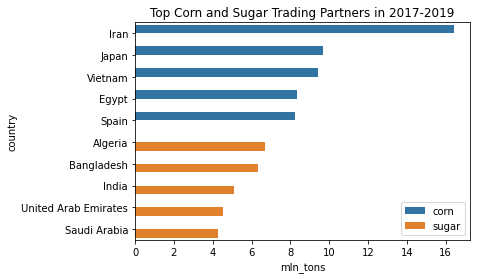

In [24]:
top_partners = top_partners_usd.reset_index()
sns.barplot(y='country', x='mln_tons', hue='product', data=top_partners, orient='h')
plt.title('Top Corn and Sugar Trading Partners in 2017-2019')
plt.legend(loc='lower right');

### Top Exporter States Per Product 

In [25]:
def top_exporters(df=df, terms='usd'):
    df = df.loc[df['type'] == 'Export', ['product','state', terms]] \
            .groupby(['product', 'state']) \
            .sum()
    
    df['bln_' + str(terms)] = df[terms].div(1e9)
    
    groups = df['bln_' + str(terms)].groupby(['product'], group_keys=False)
    top_states = groups.apply(lambda x: x.sort_values(ascending=False).head(5))
    
    top_states = top_states.reset_index()
    
    return top_states

In [26]:
top_states = top_exporters(df=df, terms='usd')
top_states

product state  bln_usd
0           corn    MT   28.376
1           corn    PR    9.161
2           corn    GO    5.707
3           corn    MS    3.405
4           corn    SP    1.511
5   soybean_meal    MT   27.995
6   soybean_meal    PR   24.650
7   soybean_meal    RS   15.007
8   soybean_meal    GO    9.421
9   soybean_meal    BA    5.439
10   soybean_oil    PR   11.109
11   soybean_oil    RS    6.282
12   soybean_oil    MT    5.435
13   soybean_oil    SC    1.239
14   soybean_oil    GO    0.856
15      soybeans    MT   80.507
16      soybeans    PR   48.484
17      soybeans    RS   46.137
18      soybeans    GO   21.269
19      soybeans    MS   13.285
20         sugar    SP   66.212
21         sugar    MG    8.559
22         sugar    PR    8.271
23         sugar    AL    4.826
24         sugar    MS    3.219
25         wheat    RS    1.556
26         wheat    PR    0.184
27         wheat    SC    0.025
28         wheat    SP    0.002
29         wheat    MS    0.000

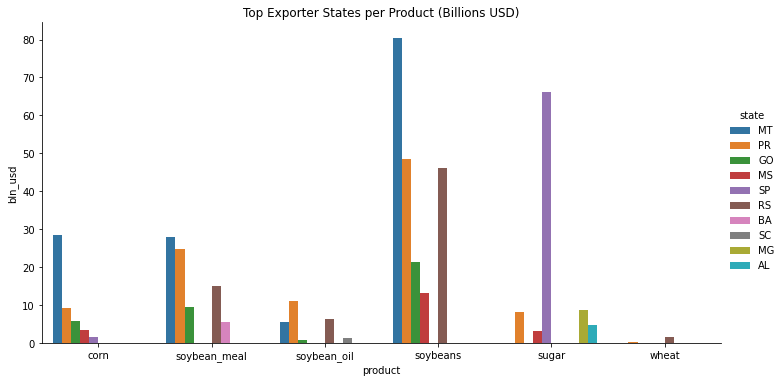

In [27]:
sns.catplot(kind='bar', hue='state', x='product', y='bln_usd', data=top_states, aspect=2)
plt.title('Top Exporter States per Product (Billions USD)')
plt.show()

### Forecasts of Brazil's Export of Soybeans, Soybean Meal, and Corn for 2020-2030 

In [28]:
covariates = pd.read_excel('covariates.xlsx', engine='openpyxl')
covariates.head()

year  price_soybeans  price_corn  price_soybean_meal  gdp_china  \
0 1979.000             nan         nan                 nan    100.000   
1 1980.000         100.000     100.000             100.000    107.900   
2 1981.000          98.526     103.888              99.805    113.403   
3 1982.000          83.406      85.986              86.597    123.609   
4 1983.000          97.852     108.168              98.663    136.959   

   gdp_iran  gpd_netherlands  gdp_spain  gdp_thailand  gdp_world  gdp_egypt  \
0   100.000              nan    100.000       100.000    100.000    100.000   
1    81.200          100.000    101.200       104.600    102.100    103.400   
2    74.217           99.500    100.795       110.771    104.040    105.675   
3    83.939           98.207    102.005       116.753    104.664    113.389   
4    95.523           99.974    103.739       123.291    107.595    123.481   

   gdp_japan  gdp_vietnam  
0    100.000      100.000  
1    103.200       96.500  
2    107.534      102.097  
3    111.083      110.469  
4    114.971      118.312

In [29]:
# Drop irrelevant data (rows with NaN and data before 1997, since we have no label for these)
covariates.dropna(inplace=True)

past_data = covariates['year'] < 1997
future_data = covariates['year'] > 2019

past_covariates = covariates.drop(covariates[past_data | future_data].index, axis=0)

In [30]:
filter_products = df['product'].isin(['soybeans', 'soybean_meal', 'corn'])
filter_type = df['type'] == 'Export'

past_export = df.loc[filter_products & filter_type, ['product', 'date', 'tons']] \
                  .groupby(['date', 'product']) \
                  .sum()

past_export.reset_index(inplace=True)

In [31]:
past_export = pd.pivot(data=past_export, index='date', columns='product', values='tons')
past_export.reset_index(col_level=1, inplace=True)
past_export['year'] = pd.DatetimeIndex(past_export['date']).year
past_export.head()

product       date       corn  soybean_meal    soybeans  year
0       1997-01-01 170407.730    486775.060   14030.000  1997
1       1997-02-01  96868.464    176535.716   17095.000  1997
2       1997-03-01  48452.425    575665.522  550157.554  1997
3       1997-04-01  30821.130   1208243.618 1589692.909  1997
4       1997-05-01   1855.510   1269342.616 1644029.748  1997

In [32]:
# Check if Brazil exports each product to each one of the countries
countries = ['China', 'Iran', 'Netherlands', 'Spain', 'Thailand', 'Egypt', 'Japan', 'Vietnam']
products = ['soybeans', 'soybean_meal', 'corn']
for product in products:
    for country in countries:
        records = df[(df['product'] == product) & (df['country'] == country)]
        if len(records) == 0:
            print(product, country)

In [33]:
def forecast_annual_export(past_export=past_export, covariates=covariates, product='soybeans'):
    
    # Filter relevant data
    past_covariates = covariates[covariates['year'] > 1996]
    past_covariates = pd.concat([past_covariates[['year', 'price_' + str(product)]], 
                                 past_covariates.iloc[:, 4:]], 
                                 axis=1)
    past_export = past_export[['date', 'year', product]]
    
    # Join
    data = past_export.merge(past_covariates, how='left', on='year')
    
    # Clean dataframe
    data.drop('year', axis=1, inplace=True)
    data.rename(columns={'date': 'ds'}, inplace=True)
    data.rename(columns={product: 'y'}, inplace=True)
    
    # Split dataset
    train = data.drop(data.index[-12:])
    test = data[-12:]
    x_test = test.drop('y', axis=1)
    y_test = test['y'].values
    
    # Define model
    model = Prophet()
    model.add_regressor('price_' + str(product))
    
    for regressor in data.columns[-9:]:
        model.add_regressor(regressor)
    
    # Fit model
    model.fit(train)
    
    # Predict on test set
    forecast = model.predict(x_test)
    
    # Evaluate
    print("Evaluation step")
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error: %.3f' % mae)

    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()
    
    # Prepare future data to forecast
    future = []
    for year in range(20, 31):
        for month in range(1, 13):
            date = f'20{year}-{month:02d}'
            future.append([date])
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['year'] = pd.DatetimeIndex(future['ds']).year

    future_covariates = covariates[future_data]
    future_covariates = pd.concat([future_covariates[['year', 'price_' + str(product)]], 
                                   future_covariates.iloc[:, 4:]], 
                                   axis=1)
    
    future = future.merge(future_covariates, how='left', on='year')
    future.drop('year', axis=1, inplace=True)

    # Forecast
    print("Forecast step")
    future_forecast = model.predict(future)
    model.plot(future_forecast)
    plt.show()
    
    # Aggregate annual forecast
    future_forecast['year'] = pd.DatetimeIndex(future_forecast['ds']).year
    annual_forecast = future_forecast[['year', 'yhat']].groupby('year').sum()
    
    annual_forecast['yhat'] = annual_forecast['yhat'].div(1e6)
    sns.lineplot(data=annual_forecast, x='year', y='yhat')
    plt.title(f'Export Forecast for 2020-2030 - {product}')
    plt.ylabel('million of tons');

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluation step
Mean Absolute Error: 2283707.244


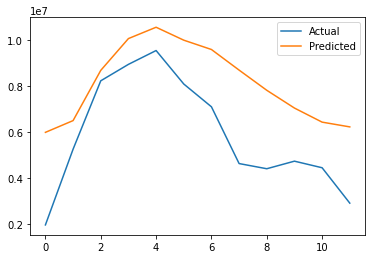

Forecast step


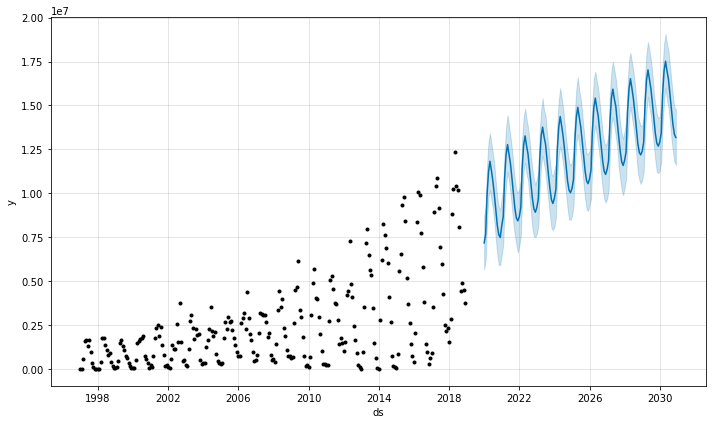

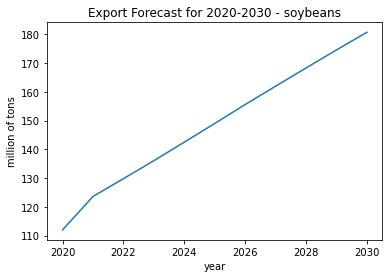

In [34]:
forecast_annual_export(product='soybeans')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluation step
Mean Absolute Error: 123217.125


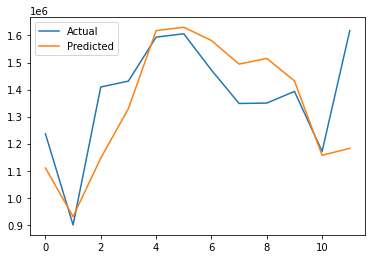

Forecast step


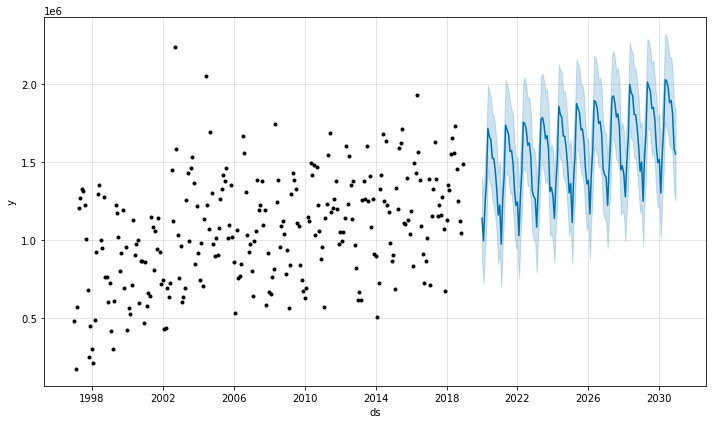

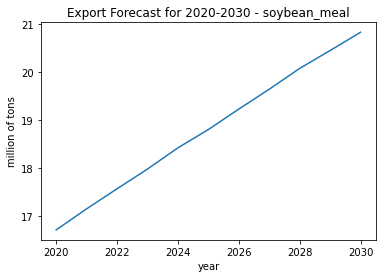

In [35]:
forecast_annual_export(product='soybean_meal')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluation step
Mean Absolute Error: 1835419.697


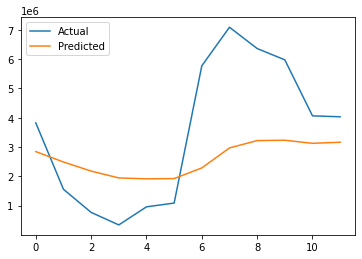

Forecast step


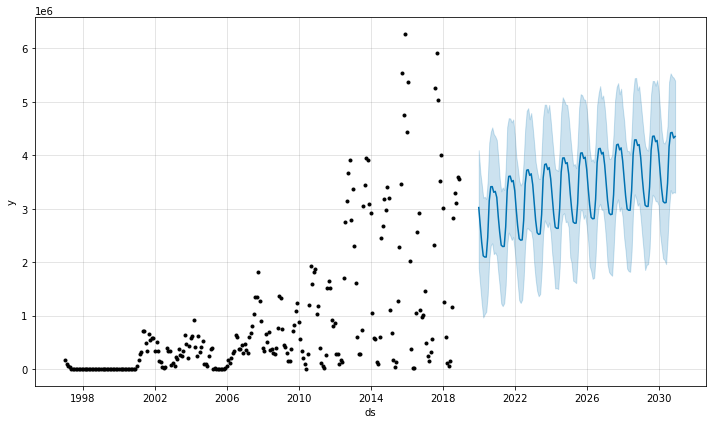

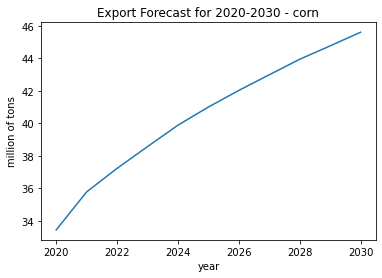

In [36]:
forecast_annual_export(product='corn')